# First Medium Post
Insights on 2022 NFL rushing/passing statistics

In [296]:
#import libraries
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [297]:
#create headers to help access the api
headers = {
    'X-RapidAPI-Key': '493792c7admsha8914888073399bp15ccfajsna326b3210af4',
    'X-RapidAPI-Host': 'nfl-team-stats.p.rapidapi.com'
}

In [298]:
#Define URLs for 2022 pass and rush statistics
pass_url = 'https://nfl-team-stats.p.rapidapi.com/v1/nfl-stats/teams/passing-stats/offense/2022'
rush_url = 'https://nfl-team-stats.p.rapidapi.com/v1/nfl-stats/teams/rushing-stats/offense/2022'
wins_url = 'https://nfl-team-stats.p.rapidapi.com/v1/nfl-stats/teams/win-stats/2022'


In [299]:
#create Jsons for each set of data
pass_response = requests.request("GET", pass_url, headers=headers)
passing = pass_response.text
pass_data = json.loads(passing)

rush_response = requests.request("GET", rush_url, headers=headers)
rushing = rush_response.text
rush_data = json.loads(rushing)

wins_response = requests.request("GET", wins_url, headers=headers)
wins = wins_response.text
wins_data = json.loads(wins)

In [300]:
#convert the Jsons to more workable dataframes
pass_df = pd.DataFrame.from_dict(pass_data['_embedded']['teamPassingStatsList']).drop(columns='_links')
rush_df = pd.DataFrame.from_dict(rush_data['_embedded']['teamRushingStatsList']).drop(columns='_links')
wins_df = pd.DataFrame.from_dict(wins_data['_embedded']['teamWinStatsList']).drop(columns='_links')


In [313]:
#sort the dataframes and prepare to combine them into one
pass_combine = pass_df.sort_values('name').rename(columns={'passYards':'pass_yds','touchdowns':'pass_tds'}).reset_index().drop(columns='index')
rush_combine = rush_df.sort_values('name').reset_index().drop(columns='index')
wins_combine = wins_df.sort_values('name')

#create new list of names for wins df without city names
new_names = []
for i in wins_combine['name']:
    for j in pass_combine['name']:
        if j in i:
            new_names.append(j)
            
#add new name values that match the other two dataframes and sort            
wins_combine.drop(columns='name', inplace=True)
wins_combine.insert(0, 'name', new_names)
wins_combine.sort_values('name', ascending=True, inplace=True)
wins_combine = wins_combine.reset_index().drop(columns='index')

#combine into one dataframe
combined_df = pass_combine.assign(rush_yds=rush_combine['yards'],
                                 rush_tds=rush_combine['touchdowns'],
                                 wins=wins_combine['wins'],
                                 losses=wins_combine['losses'],
                                 win_pct=wins_combine['winRatePercentage'])


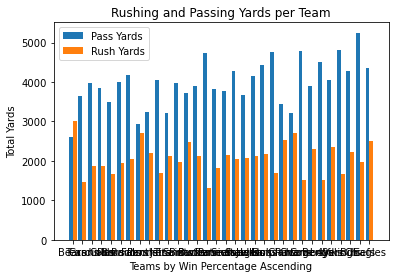

In [314]:
#Create visuals to examine relationships between rushing, passing, winning, and touchdowns

#Question 1: Do teams with more passing yards than rushing yards tend to win more?
#Graph 1: bar graph of each teams pass tds and rush tds, sorted by win_pct on the x-axis
win_sorted_df = combined_df.sort_values('win_pct', ascending=True).reset_index().drop(columns='index')
X_axis = np.arange(len(win_sorted_df['win_pct']))


plt.bar(X_axis - 0.2, win_sorted_df['pass_yds'], 0.4, label = 'Pass Yards')
plt.bar(X_axis + 0.2, win_sorted_df['rush_yds'], 0.4, label = 'Rush Yards')
  
plt.xticks(X_axis, win_sorted_df['name'])
plt.xlabel("Teams by Win Percentage Ascending")
plt.ylabel("Total Yards")
plt.title("Rushing and Passing Yards per Team")
plt.legend()
plt.show()


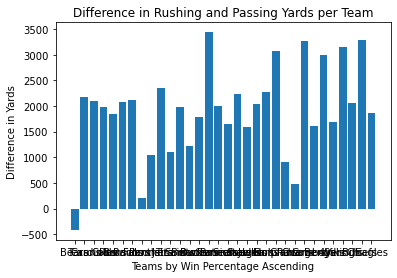

In [315]:
#Graph 2: Bar graph representing difference between passing and rushing yards, sorted by win_pct on x-axis

#Create new column of difference between pass and rush yds for each team
yds_dif_list = []
for i in np.arange(len(win_sorted_df['name'])):
    dif = win_sorted_df['pass_yds'][i] - win_sorted_df['rush_yds'][i]
    yds_dif_list.append(dif)
        
yards_dif_df = win_sorted_df.assign(yds_dif=yds_dif_list)
yards_dif_df.head()

#Create Graph
plt.bar(X_axis, yards_dif_df['yds_dif'])
plt.xticks(X_axis, yards_dif_df['name'])
plt.xlabel("Teams by Win Percentage Ascending")
plt.ylabel("Difference in Yards")
plt.title("Difference in Rushing and Passing Yards per Team")
plt.show()


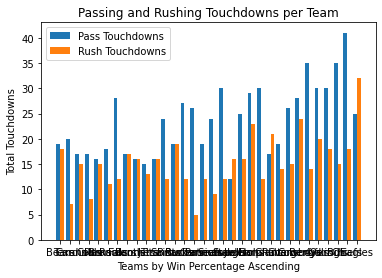

In [316]:
#Question 2: Do teams with more passing touchdowns than rushing touchdowns tend to win more?
#Graph 3: Bar graph of rushing and passing touchdowns, sorted by win_pct on the x-axis
plt.bar(X_axis - 0.2, win_sorted_df['pass_tds'], 0.4, label = 'Pass Touchdowns')
plt.bar(X_axis + 0.2, win_sorted_df['rush_tds'], 0.4, label = 'Rush Touchdowns')
  
plt.xticks(X_axis, win_sorted_df['name'])
plt.xlabel("Teams by Win Percentage Ascending")
plt.ylabel("Total Touchdowns")
plt.title("Passing and Rushing Touchdowns per Team")
plt.legend()
plt.show()


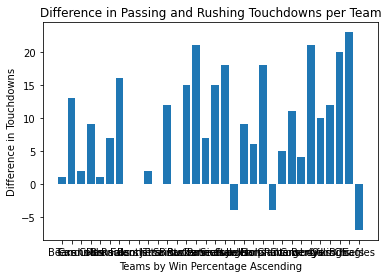

In [317]:
#Graph 4: Bar graph of difference between pass and rush tds per team, sorted by win_pct on x-axis
tds_dif_list = []
for i in np.arange(len(win_sorted_df['name'])):
    dif = win_sorted_df['pass_tds'][i] - win_sorted_df['rush_tds'][i]
    tds_dif_list.append(dif)
        
tds_dif_df = win_sorted_df.assign(tds_dif=tds_dif_list)

#Create Graph
plt.bar(X_axis, tds_dif_df['tds_dif'])
plt.xticks(X_axis, yards_dif_df['name'])
plt.xlabel("Teams by Win Percentage Ascending")
plt.ylabel("Difference in Touchdowns")
plt.title("Difference in Passing and Rushing Touchdowns per Team")
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

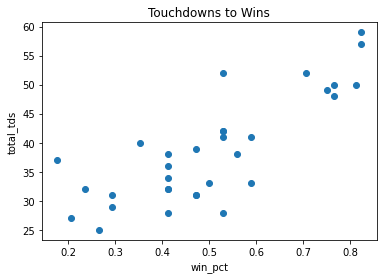

In [318]:
#Question 3: Does the amount of touchdowns scored by a team affect winningness?
#Graph 5: Scatter Plot of touchdowns on the y-axis and win_pct on the x-axis

#create summed tds column for each team
tds_sum_list = []
for i in np.arange(len(win_sorted_df['name'])):
    td_sum = win_sorted_df['pass_tds'][i] + win_sorted_df['rush_tds'][i]
    tds_sum_list.append(td_sum)
        
tds_sum_df = win_sorted_df.assign(total_tds=tds_sum_list)

#Create Plot
plt.scatter(x=tds_sum_df['win_pct'], y=tds_sum_df['total_tds'])
plt.xlabel('win_pct')
plt.ylabel('total_tds')
plt.title('Touchdowns to Wins')
plt.show
